<div style="text-align: left; background-color:#5A96E3; font-family:Arial; color:white; padding: 12px; line-height:1.25; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px; border-style: solid; border-color: #023468;">
    KHÁM PHÁ VÀ PHÂN TÍCH DỮ LIỆU
</div>

Import các thư viện cần thiết

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as gp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

Đọc dữ liệu đã được tiền xử lý

In [26]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,age,sex,race,marital_status,education,employment_status,income_level,books_read_last_12m,read_printed_books_last_12m,read_audiobooks_last_12m,read_ebooks_last_12m,last_book_read_source,read_daily_news,read_magazines_journals
0,46,Male,Native American,Married,High school,Employed full-time,<$10k,97,Yes,Yes,Yes,Purchased,Yes,Yes
1,32,Male,Mixed race,Never been married,High school,Employed full-time,<$10k,97,No,Yes,Yes,Borrowed from others,Yes,Yes
2,27,Male,Mixed race,Married,High school,Employed full-time,$40k-50k,97,Yes,No,Yes,Borrowed from library,Yes,No
3,16,Female,Mixed race,Never been married,Some high school,Employed part-time,$10k-20k,97,Yes,Yes,No,Purchased,Yes,No
4,55,Female,Asian/Pacific Islander,Divorced,Some college,Self-employed,$40k-50k,97,Yes,Yes,Yes,Purchased,No,No


# **A. TỔNG QUAN**

Trước khi tiến hành phân tích, nhóm kiểm tra mối tương quan giữa các biến trong tập dữ liệu.

In [27]:
# Định nghĩa hai hàm
# prepare_correlation_data(df): Chuẩn bị dữ liệu để tính toán tương quan bằng cách chuyển đổi các biến định tính thành định lượng
# plot_correlation_matrix(df): Tạo và hiển thị ma trận tương quan (correlation matrix) bằng biểu đồ nhiệt (heatmap)

def prepare_correlation_data(df):
    df_corr = df.copy()
    yes_no_columns = [
        'read_printed_books_last_12m',
        'read_audiobooks_last_12m', 
        'read_ebooks_last_12m',
        'read_daily_news',
        'read_magazines_journals'
    ]
    
    for col in yes_no_columns:
        df_corr[col] = (df_corr[col] == 'Yes').astype(int)
    
    categorical_columns = [
        'sex',
        'race',
        'marital_status',
        'education',
        'employment_status',
        'income_level',
        'last_book_read_source'
    ]
    
    for col in categorical_columns:
        df_corr[col] = LabelEncoder().fit_transform(df_corr[col])
    return df_corr

def plot_correlation_matrix(df_corr):
    corr_matrix = df_corr.corr()
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, 
                annot=True,           
                cmap='coolwarm',      
                center=0,             
                fmt='.2f',            
                square=True,          
                linewidths=0.5,       
                cbar_kws={"shrink": .5}  
               )
    
    plt.title('Ma trận tương quan giữa các biến', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

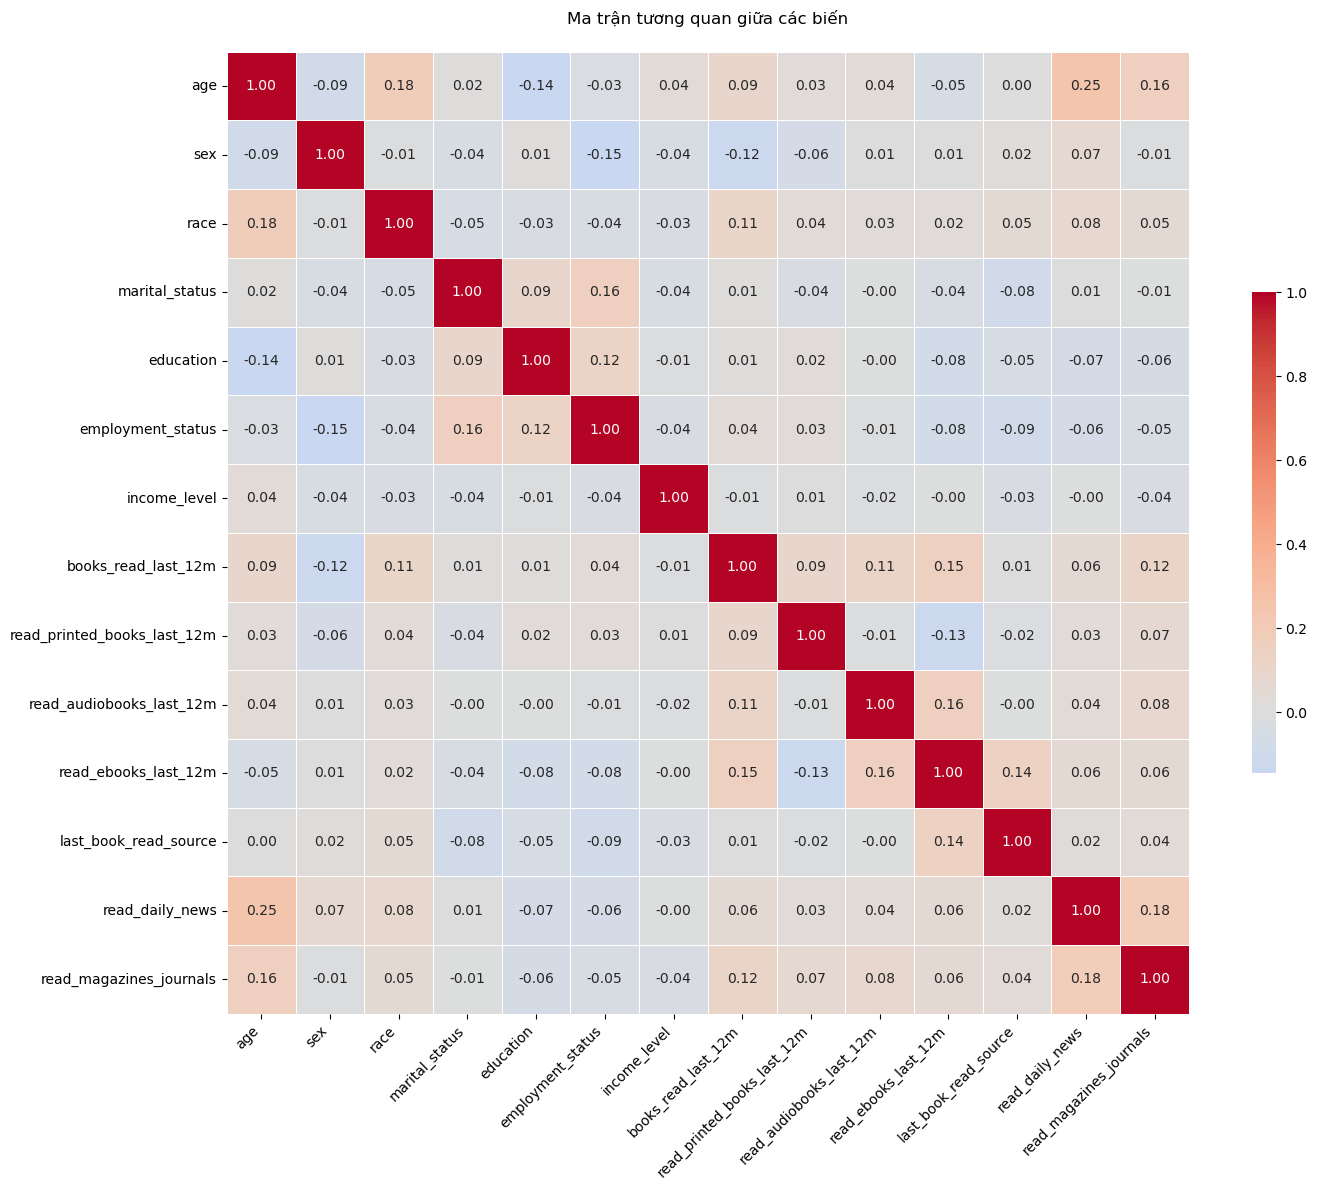

In [28]:
# Vẽ ma trận tương quan cho bộ dữ liệu

df0 = df.copy()    

df_corr = prepare_correlation_data(df0)
plot_correlation_matrix(df_corr)
corr_matrix = df_corr.corr()
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.3:
            strong_correlations.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

strong_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

**Nhận xét** 
- Tương quan giữa các đặc điểm nhân khẩu học:
    - Tuổi (age) và chủng tộc (race) có tương quan dương nhẹ (0.18)
    - Tuổi và trình độ học vấn (education) có tương quan âm nhẹ (-0.14)
    - Giới tính (sex) và tình trạng việc làm (employment_status) có tương quan âm nhẹ (-0.15)
    - Các tương quan khác trong nhóm này đều rất yếu (gần 0)
- Tương quan trong nhóm thói quen đọc:
    - Đọc sách điện tử (read_ebooks) và nghe sách nói (read_audiobooks) có tương quan dương nhẹ (0.16)
    - Đọc tin tức hàng ngày (read_daily_news) và đọc tạp chí/tạp chí khoa học (read_magazines_journals) có tương quan dương (0.18)
    - Đọc sách điện tử và nguồn sách đọc gần đây (last_book_read_source) có tương quan dương (0.14)
    - Số sách đọc trong 12 tháng (books_read_last_12m) có tương quan dương nhẹ với đọc sách điện tử (0.15)
- Tương quan giữa nhân khẩu học và thói quen đọc:
    - Tuổi có tương quan dương đáng kể với đọc tin tức hàng ngày (0.25)
    - Tuổi cũng có tương quan dương nhẹ với đọc tạp chí/tạp chí khoa học (0.16)
    - Giới tính có tương quan âm nhẹ với số sách đọc trong 12 tháng (-0.12)
    - Thu nhập (income_level) hầu như không có tương quan với bất kỳ thói quen đọc nào (các hệ số gần 0)

# **B. CÂU HỎI**

## CÂU 1. MỨC ĐỘ HỌC VẤN CAO HƠN CÓ THỰC SỰ DẪN ĐẾN THÓI QUEN ĐỌC ĐA DẠNG HƠN KHÔNG?

### 1. Lợi ích của việc trả lời câu hỏi

Việc nghiên cứu mối quan hệ giữa học vấn và đa dạng thói quen đọc mang lại lợi ích cho nhiều bên: hỗ trợ nhà xuất bản tối ưu sản phẩm theo phân khúc, đồng thời cung cấp dữ liệu để cải thiện văn hóa đọc hiệu quả và phục vụ nghiên cứu khoa học.

### 2. Tiền xử lý

**a. Mô tả thuật toán**

* Tạo biểu đồ radar so sánh thói quen đọc theo học vấn:
    * Tính tỷ lệ người đọc từng format trong mỗi nhóm học vấn
    * Vẽ biểu đồ radar với 5 trục tương ứng 5 format đọc
    * Mỗi đường trong biểu đồ thể hiện một nhóm học vấn
    * Càng xa tâm thể hiện tỷ lệ đọc format đó càng cao

Biểu đồ này giúp trực quan hóa sự khác biệt về thói quen đọc giữa các nhóm trình độ học vấn khác nhau.

**b. Code**

In [29]:
df1 = df.copy()

In [30]:
categories = ['Printed Books', 'Audiobooks', 'Ebooks', 'Daily News', 'Magazines']
    
def normalize_reading(series):
    return (series == 'Yes').astype(float).mean()

reading_by_education = df1.groupby('education').agg({
        'read_printed_books_last_12m': normalize_reading,
        'read_audiobooks_last_12m': normalize_reading,
        'read_ebooks_last_12m': normalize_reading,
        'read_daily_news': normalize_reading,
        'read_magazines_journals': normalize_reading
    })
    

<Figure size 1500x1000 with 0 Axes>

### 3. Trực quan

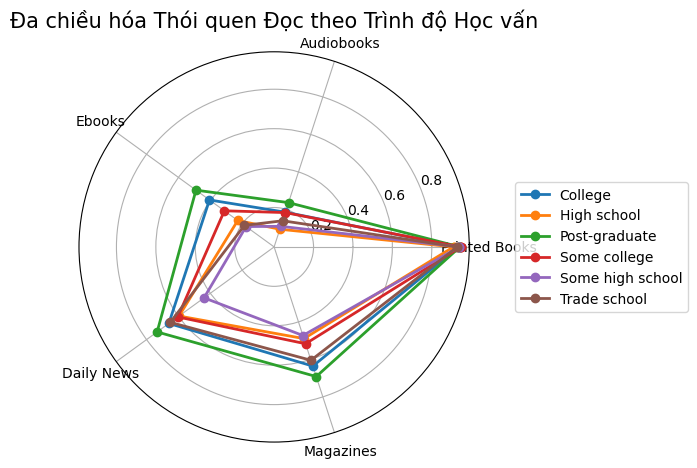

In [31]:
# Vẽ biểu đồ radar
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
    
plt.subplot(polar=True)
for idx, education in enumerate(reading_by_education.index):
        values = reading_by_education.loc[education].values
        values = np.concatenate((values, [values[0]]))
        
        plt.polar(angles, values, 'o-', linewidth=2, 
                  label=f'{education}')
    
plt.thetagrids(angles[:-1] * 180/np.pi, categories)
plt.title('Đa chiều hóa Thói quen Đọc theo Trình độ Học vấn', size=15)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.show()


### 4. Nhận xét chung

Từ biểu đồ radar về thói quen đọc theo trình độ học vấn, rút ra nhận xét như sau:

- Xu hướng đọc theo trình độ học vấn:
    - Nhóm có học vấn cao (Post-graduate và College graduate) thể hiện mức độ đọc đa dạng vượt trội
    - Diện tích đường radar của họ lớn nhất, cho thấy sự tích cực trong việc sử dụng nhiều format đọc
    - Nhóm có học vấn thấp hơn (High school incomplete) có xu hướng đọc ít đa dạng hơn, tập trung chủ yếu vào một số format truyền thống

- So sánh giữa các format đọc:
    - Sách in (Printed Books) là format phổ biến và được sử dụng đều đặn ở mọi nhóm học vấn
    - Audiobooks và Ebooks cho thấy sự phân hóa rõ rệt, được ưa chuộng hơn ở nhóm có học vấn cao
    - Tin tức hàng ngày (Daily News) và tạp chí (Magazines) cũng được nhóm học vấn cao tiêu thụ nhiều hơn

- Xu hướng công nghệ và học vấn:
    - Nhóm có học vấn cao thích nghi tốt với các format đọc hiện đại
    - Họ có xu hướng kết hợp nhiều format đọc khác nhau
    - Nhóm học vấn thấp hơn có vẻ chậm trong việc áp dụng các công nghệ đọc mới


**Kết luận** Mức độ học vấn cao hơn không chỉ dẫn đến thói quen đọc đa dạng hơn mà còn thể hiện sự thích nghi tốt với các format đọc hiện đại. Điều này có thể là do họ có khả năng tiếp cận công nghệ tốt hơn, nhu cầu thông tin đa dạng hơn, và có thể là điều kiện kinh tế thuận lợi hơn để tiếp cận nhiều format đọc khác nhau. Phát hiện này có ý nghĩa quan trọng trong việc phát triển chính sách giáo dục, chiến lược xuất bản và các chương trình khuyến đọc phù hợp với từng nhóm đối tượng.

## CÂU 2. NẾU XÉT RIÊNG VỀ CÁC ẤN PHẨM ĐỊNH KỲ, SỰ ƯA THÍCH CÁC ẤN PHẨM NÀY CÓ SỰ KHÁC BIỆT THEO ĐỘ TUỔI VÀ TRÌNH ĐỘ HỌC VẤN NHƯ THẾ NÀO?

### 1. Lợi ích của việc trả lời câu hỏi

- Tìm hiểu về mức độ quan tâm tới các ấn phẩm định kỳ giúp hiểu được thói quen đọc các thể loại sách báo, tạp chí của từng lứa tuổi và trình độ học vấn, từ đó xác định mức độ yêu thích xem các loại ấn phẩm này theo độ tuổi và trình độ học vấn.
- Việc khám phá sở thích đọc sách báo của mỗi người giúp cho các nhà phát hành sách và bản tin có chiến lược phù hợp để đưa nguồn sách này tiếp cận tới đúng đối tượng quan tâm nó.

### 2. Tiền xử lý

#### a) Mô tả thuật toán

- Để trả lời câu hỏi này, nhóm sử dụng thông tin của các cột **read_daily_news**, **read_magazines_journals**, **age** và **education**.

- Thuật toán sẽ theo các bước sau:

    + Nhóm độ tuổi theo các nhóm tuổi [(15-25), (25-35), (35-45), (45-55), (55-65), (65-75), (75-85), (85-95)].

    + Tạo dataframe chứa thông tin về hành vi đọc các ấn phẩm theo kỳ theo độ tuổi và trình độ học vấn.

    + Nhóm số người đọc các ấn phẩm in theo nhóm tuổi và trình độ học vấn. 

    + Đặt trình độ học vấn làm index theo thứ tự tự định nghĩa cho 2 nhóm người đọc sách báo và người đọc tạp chí.

#### b) Code

In [32]:
# Xác định khoảng giá trị (bins) và nhãn (labels)
age_bins = [15, 25, 35, 45, 55, 65, 75, 85, 95]
age_labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85-95']

In [33]:
# Tạo dataframe chứa thông tin về hành vi đọc các ấn phẩm theo kỳ theo độ tuổi và trình độ học vấn
printed_media_df = pd.DataFrame()
printed_media_df['age'] = df['age']
printed_media_df['read_daily_news'] = df['read_daily_news']
printed_media_df['read_magazines_journals'] = df['read_magazines_journals']
printed_media_df['education'] = df['education']
printed_media_df['age_group'] = pd.cut(printed_media_df['age'], bins=age_bins, labels=age_labels, right=False)
printed_media_df.head(10)

,age,read_daily_news,read_magazines_journals,education,age_group
0,46,Yes,Yes,High school,45-55
1,32,Yes,Yes,High school,25-35
2,27,Yes,No,High school,25-35
3,16,Yes,No,Some high school,15-25
4,55,No,No,Some college,55-65
5,63,Yes,No,Some college,55-65
6,60,Yes,Yes,College,55-65
7,50,Yes,No,Post-graduate,45-55
8,29,No,No,High school,25-35
9,23,Yes,Yes,High school,15-25


In [34]:
# Tạo dataframe để vẽ biểu đồ nhiêt
newspaper_count_df = printed_media_df[printed_media_df['read_daily_news'] == 'Yes']

grouped_newspaper_df = newspaper_count_df.groupby(['education', 'age_group']).size().reset_index(name='Count')

pivot_table_newspaper = grouped_newspaper_df.pivot(index='education', columns='age_group', values='Count').fillna(0)

education_order = ['Some high school', 'High school', 'Trade school', 'Some college', 'College', 'Post-graduate']
pivot_table_newspaper.index = pd.Categorical(pivot_table_newspaper.index, categories=education_order, ordered=True)
pivot_table_newspaper.sort_index(inplace=True)
pivot_table_newspaper

age_group,15-25,25-35,35-45,45-55,55-65,65-75,75-85,85-95
Some high school,45,3,6,6,8,8,4,0
High school,39,41,30,47,53,37,17,8
Trade school,2,4,6,4,6,3,3,0
Some college,46,38,34,75,54,43,15,5
College,16,48,58,68,65,47,16,3
Post-graduate,5,43,56,48,71,46,24,2


In [35]:
# Tương tự cho magazine
magazine_count_df = printed_media_df[printed_media_df['read_magazines_journals'] == 'Yes']

grouped_nagazine_df = magazine_count_df.groupby(['education', 'age_group']).size().reset_index(name='Count')

pivot_table_magazine = grouped_nagazine_df.pivot(index='education', columns='age_group', values='Count').fillna(0)

pivot_table_magazine.index = pd.Categorical(pivot_table_magazine.index, categories=education_order, ordered=True)
pivot_table_magazine.sort_index(inplace=True)
pivot_table_magazine

age_group,15-25,25-35,35-45,45-55,55-65,65-75,75-85,85-95
Some high school,57,2,6,6,5,8,2,0
High school,41,34,19,36,41,29,17,6
Trade school,3,4,4,6,5,2,2,0
Some college,43,34,39,64,38,32,11,4
College,14,39,68,73,58,41,13,3
Post-graduate,4,32,50,52,69,47,21,3


### 3. Trực quan

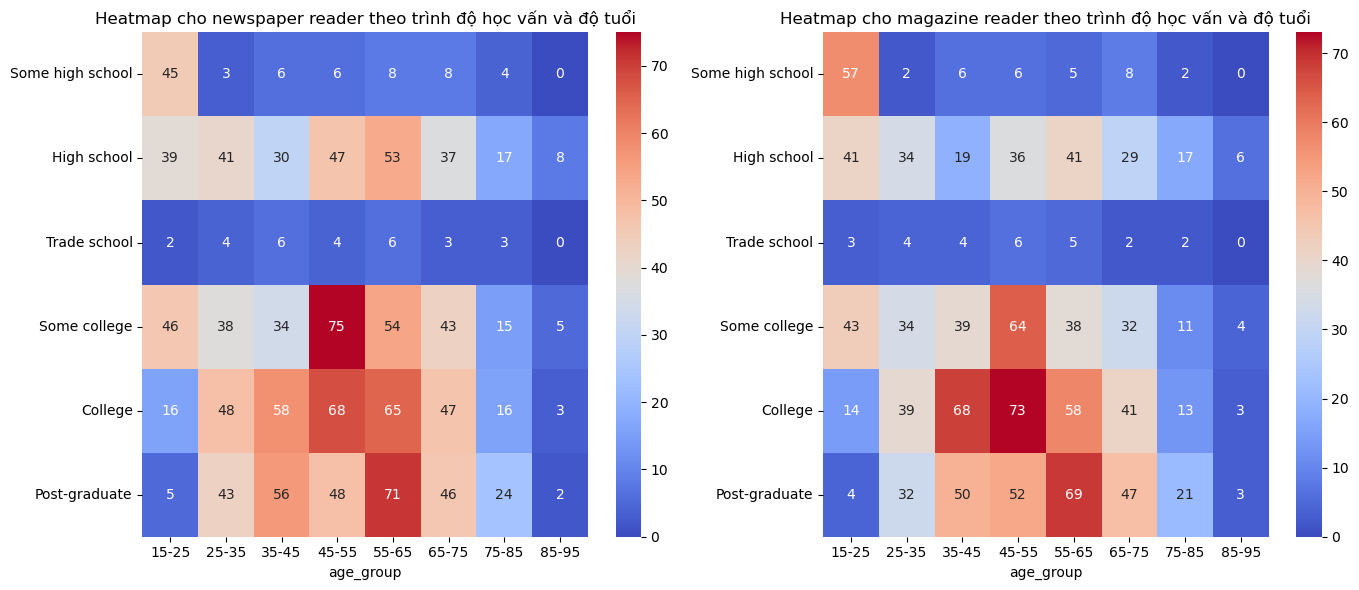

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap cho newspaper reader
sns.heatmap(
    pivot_table_newspaper, 
    ax=axes[0],
    cmap="coolwarm",  
    annot=True,
    cbar=True
)
axes[0].set_title("Heatmap cho newspaper reader theo trình độ học vấn và độ tuổi")

# Heatmap cho magazine reader
sns.heatmap(
    pivot_table_magazine, 
    ax=axes[1],
    cmap="coolwarm",  
    annot=True,
    cbar=True
)
axes[1].set_title("Heatmap cho magazine reader theo trình độ học vấn và độ tuổi")

plt.tight_layout()
plt.show()

### 4. Nhận xét và rút ra kết luận.

- Nhận xét:
    + Nhìn chung, số lượng người đọc giảm dần ở các độ tuổi lớn hơn, đặc biệt là ở độ tuổi từ 65 trở đi.

    + Nhóm đang chưa hoàn thành bậc trung học phổ thông (Some high school) và nhóm người đang học các trường cao đẳng nghề (Trade school) có số lượng đọc thấp hơn đáng kể so với các nhóm có trình độ học vấn khác.

    + 2 nhóm người: người đã hoàn thành bậc đại học (college) và chưa hoàn thành bậc đại học (some college) ở độ tuổi từ 45-55 và 55-65 có đọc các ấn phẩm in ấn định kỳ nhiều nhất. Độ tuổi từ 35 - 45 cũng có sự ưa thích nhất định với thể loại ấn phẩm này. 

- Kết luận:
    + Độ tuổi từ 35-65 là nhóm tiêu thụ chính cả newspaper và magazine. Điều này cho thấy nhóm trung niên và lớn tuổi có thói quen đọc các ấn phẩm định kì nhiều hơn. Lý do có thể là vì các nội dung của các ấn phẩm này phù hợp thị hiếu của độ tuổi trung niên hơn hơn.
    + Nhóm có trình độ học vấn cao từ bậc đại học trở lên có xu hướng đọc nhiều hơn các ấn phẩm định kỳ. Đây là nhóm có thể quan tâm đến các nội dung chuyên sâu hoặc phù hợp với nghề nghiệp và sở thích của họ. Ngoài ra, nhóm có trình độ học vấn trung học phổ thông cũng đọc có xu hướng đọc nhiều.

## CÂU 3. SỐ LƯỢNG SÁCH ĐỌC THAY ĐỔI NHƯ THẾ NÀO THEO MỨC THU NHẬP VÀ GIỚI TÍNH?

### 1. Lợi ích của việc trả lời câu hỏi


- Trả lời câu hỏi này giúp tìm hiểu xem mức thu nhập ảnh hưởng tới sự thay đổi thói quen đọc sách của nam và nữ như thế nào? Liệu nam giới hoặc nữ giới có thích đọc sách hơn giới tính còn lại hay không. Từ đó phát triển chiến lược tiếp thị phù hợp với từng cá nhân theo giới tính và mức thu nhập.

### 2. Tiền xử lý

#### a) Mô tả thuật toán

- Để trả lời câu hỏi này, nhóm sử dụng dữ liệu của cột **income_level**, **sex** và **books_read_last_12m**.

- Thuật toán được thực hiện theo các bước sau:
    
    + Nhóm dữ liệu theo **income_level** và **sex** để tính trung bình số sách đọc theo mức thu nhập của từng giới tính.

    + Tạo 1 dataframe mới với 3 cột là **income_level**, **Male** và **Female** với dữ liệu của **Male** và **Female** là số sách đọc theo mức thu nhập của 3 giới tính nam và nữ. 

#### b) Code

In [37]:
# Tạo bảng thống kê số lượng sách của Nam và Nữ theo Income Range
book_counts = df.groupby(['income_level', 'sex'])['books_read_last_12m'].mean().reset_index()

income_level = ['<$10k', '$10k-20k','$20k-30k','$30k-40k', '$40k-50k', '$50k-75k', '$75k-100k', '$100k-150k']
book_counts_by_incomes = book_counts.pivot(index= 'income_level', columns = 'sex', values='books_read_last_12m')
book_counts_by_incomes.index = pd.Categorical(book_counts_by_incomes.index, categories=income_level, ordered=True)
book_counts_by_incomes.sort_index(inplace=True)
book_counts_by_incomes.reset_index(inplace=True)
book_counts_by_incomes.columns.name = None 

# Làm tròn thành số nguyên
book_counts_by_incomes[['Female', 'Male']] = book_counts_by_incomes[['Female', 'Male']].round(0).astype(int)
book_counts_by_incomes

,index,Female,Male
0,<$10k,17,25
1,$10k-20k,21,18
2,$20k-30k,22,15
3,$30k-40k,23,12
4,$40k-50k,20,17
5,$50k-75k,23,17
6,$75k-100k,22,15
7,$100k-150k,25,16


### 3. Trực quan

In [38]:
y_incomes = book_counts_by_incomes['index']
x_M = book_counts_by_incomes['Male'] * (-1)
x_F = book_counts_by_incomes['Female']

fig = gp.Figure() 
  
# Dữ liệu của nam giới
fig.add_trace(gp.Bar(y= y_incomes, x = x_M,  
                     name = 'Male',  
                     orientation = 'h')) 

# Dữ liệu của nữ giới
fig.add_trace(gp.Bar(y = y_incomes, x = x_F, 
                     name = 'Female', orientation = 'h'))
 
fig.update_layout(title = 'Population Pyramid', 
                 title_font_size = 22, barmode = 'relative', 
                 bargap = 0.0, bargroupgap = 0, 
                 xaxis = dict(tickvals = [-30, -25, -20, -15, -10, -5, 
                                          0, 5, 10, 15, 20, 25, 30], 
                                
                              ticktext = ['30', '25', '20', '15', '10', '5', 
                                          '0', '5', '10', '15', '20', '25', '30'], 
                                
                              title = 'Average Number of books read', 
                              title_font_size = 14) 
                 ) 
  
fig.show()

### 4. Nhận xét và rút ra kết luận.

Nhận xét
- Với mức thu nhập thấp nhất tương ứng thu nhập nằm trong khoảng dưới $10000/năm, nam giới đọc nhiều sách hơn nữ giới với trung bình số cuốn sách đọc trong 1 năm là  24 cuốn, gấp 1.6 lần nữ giới với số cuốn sách đọc trung bình là 15 cuốn. 
- Với mức thu nhập cao hơn, nữ giới đọc nhiều sách hơn nam giới. Sự chệnh lệch này giao động từ gấp 1.17 lần tới 1.91 lần. 


Kết luận

Nhìn chung, nữ giới có xu hướng đọc nhiều sách hơn nam giới. Khi thu nhập càng cao, sự khác biệt đó càng tăng. Điều này cho thấy nữ giới có xu hướng đọc sách để nâng cấp bản thân khi ở mức thu nhập cao hơn nam giới.

## CÂU 4. TÌNH TRẠNG HÔN NHÂN VÀ VIỆC ĐỌC SÁCH ĐIỆN TỬ/SÁCH IN/SÁCH NÓI TRONG MỘT NĂM CÓ MỐI QUAN HỆ NHƯ THẾ NÀO?

### 1. Lợi ích của việc trả lời câu hỏi
Hiểu rõ hơn về các nhóm độc giả, tạo ra những cơ hội mới để phát triển sản phẩm, chiến lược tiếp thị và nội dung phù hợp, đồng thời mang lại giá trị lớn cho các tổ chức trong ngành xuất bản, công nghệ và nghiên cứu hành vi tiêu dùng.

### 2. Tiền xử lý

#### a. Các thuộc tính liên quan:
- 'marital_status'
- 'read_printed_books_last_12m'
- 'read_audiobooks_last_12m'
- 'read_ebooks_last_12m'

#### b. Các bước xử lí: 
- Chuyển đổi dữ liệu: Các cột liên quan đến việc đọc sách (sách in, sách điện tử, sách nói) được chuyển đổi thành giá trị có thể phân tích (Yes/No thành 1/0).
- Tạo các nhóm theo tình trạng hôn nhân
- Kiểm tra sự phân phối: Dùng các biểu đồ tròn để xem tỷ lệ người đọc sách điện tử, sách in, sách nói theo tình trạng hôn nhân.
- Phân tích kết quả: Xem liệu có sự khác biệt rõ rệt giữa các nhóm tình trạng hôn nhân đối với việc đọc các loại sách hay không.

In [39]:
# Chuẩn hóa cột 'marital_status' thành các nhóm
def map_marital_status(status):
    if status in ['Married', 'Living with a partner']:
        return 'Married or Living with a partner'
    elif status in ['Single', 'Never been married']:
        return 'Single'
    elif status == 'Divorced':
        return 'Divorced'
    elif status == 'Widowed':
        return 'Widowed'
    elif status == 'Separated':
        return 'Separated'
    else:
        return 'Unknown'
    
df4 = df.copy()

df4['Marital Status Grouped'] = df4['marital_status'].apply(map_marital_status)
print(df4[['marital_status', 'Marital Status Grouped']].head())

       marital_status            Marital Status Grouped
0             Married  Married or Living with a partner
1  Never been married                            Single
2             Married  Married or Living with a partner
3  Never been married                            Single
4            Divorced                          Divorced


In [40]:
# Chuyển đổi các cột từ Yes/No thành 1/0
df4['read_ebooks_last_12m'] = df4['read_ebooks_last_12m'].map({'Yes': 1, 'No': 0})
df4['read_printed_books_last_12m'] = df4['read_printed_books_last_12m'].map({'Yes': 1, 'No': 0})
df4['read_audiobooks_last_12m'] = df4['read_audiobooks_last_12m'].map({'Yes': 1, 'No': 0})

### 3. Trực quan 

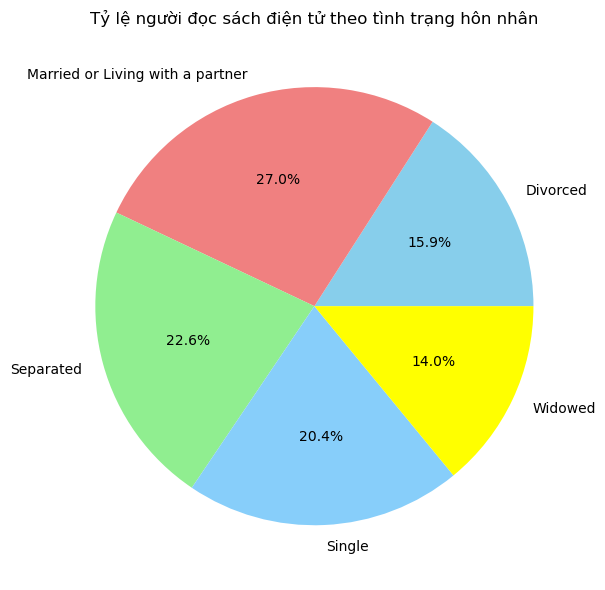

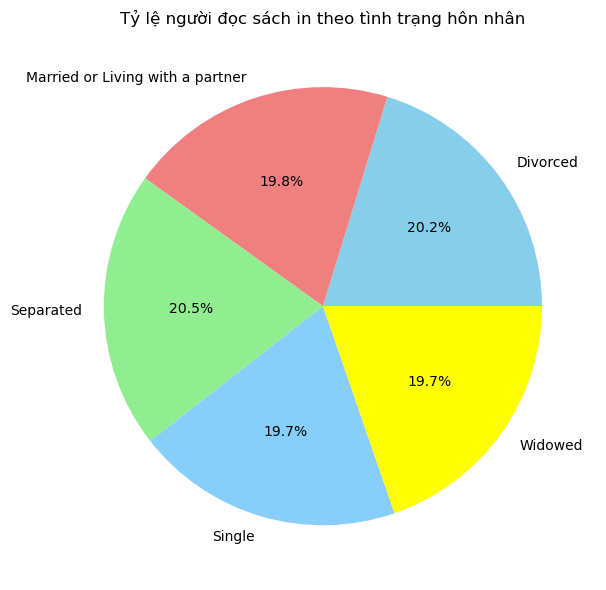

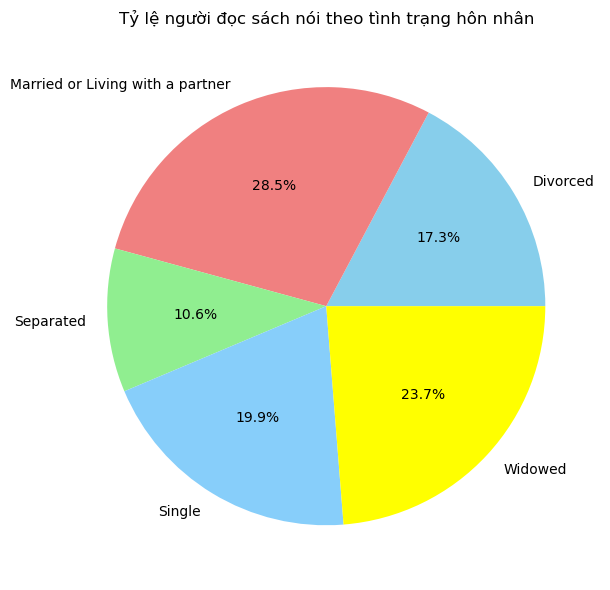

In [41]:
marital_e_books = df4.groupby('Marital Status Grouped')['read_ebooks_last_12m'].mean() 
plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách điện tử theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

marital_e_books = df4.groupby('Marital Status Grouped')['read_printed_books_last_12m'].mean() 
plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách in theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

marital_e_books = df4.groupby('Marital Status Grouped')['read_audiobooks_last_12m'].mean() 
plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách nói theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

### 4. Nhận xét chung và kết luận 
- Nhóm "Married or Living with a partner" sử dụng sách điện tử và sách nói nhiều nhất, có thể họ tận dụng lợi ích tiện lợi của chúng trong cuộc sống hàng ngày.
- Sách in phổ biến và ổn định trong mọi nhóm.
- Nhóm "Widowed" ưa chuộng sách nói, trong khi nhóm "Separated" có xu hướng ít sử dụng cả ba loại sách.

=> Như vậy, nhu cầu đọc sách thay đổi dựa trên tình trạng hôn nhân và cách mỗi nhóm sử dụng các hình thức đọc để phù hợp với lối sống của họ. Điều này cung cấp thông tin hữu ích cho các chiến lược tiếp thị và phát triển sản phẩm trong ngành xuất bản.

## CÂU 5. LIỆU CHÚNG TA CÓ THỂ DỰ ĐOÁN XEM MỘT NGƯỜI CÓ THÓI QUEN ĐỌC TẠP CHÍ KHÔNG DỰA TRÊN MỘT SỐ ĐẶC ĐIỂM NHẤT ĐỊNH? NHỮNG ĐẶC ĐIỂM NÀO CÓ THỂ DÙNG DỰ ĐOÁN THÓI QUEN ĐỌC TẠP CHÍ CỦA MỘT NGƯỜI?

Biến **read_magazine_journals** được chọn làm biến mục tiêu trong phân tích này vì nó thể hiện sự phân phối tương đối cân bằng giữa hai giá trị "Yes" và "No". Sự cân bằng này tạo điều kiện thuận lợi cho việc xây dựng và đánh giá mô hình dự đoán, bởi nó giúp hạn chế được vấn đề mất cân bằng dữ liệu (class imbalance).

### 1. Lợi ích của việc trả lời câu hỏi

* Mục đích:
    - Xây dựng mô hình dự đoán thói quen đọc tạp chí của người dùng dựa trên các đặc điểm cá nhân và thói quen đọc sách
    - Đánh giá mức độ ảnh hưởng của các yếu tố khác nhau đến thói quen đọc tạp chí
* Ý nghĩa:
    - Giúp hiểu rõ hơn về các yếu tố ảnh hưởng đến thói quen đọc tạp chí
    - Có thể ứng dụng trong việc phân khúc khách hàng và marketing cho các nhà xuất bản




### 2. Mô tả các bước xây dựng mô hình


a. Chuẩn bị dữ liệu:

-    Phân loại các biến thành 3 nhóm: yes/no, categorical và numerical
-   Chuyển đổi biến yes/no thành dạng số (1/0)
-    Mã hóa các biến categorical bằng LabelEncoder
-   Chuẩn hóa các biến numerical bằng StandardScaler

b. Xây dựng mô hình:

-    Sử dụng RandomForestClassifier với 200 cây quyết định
-    Chia dữ liệu thành tập train (80%) và test (20%)
-    Huấn luyện mô hình trên tập train

c. Đánh giá mô hình:

-    Sử dụng classification report để xem các chỉ số precision, recall, f1-score
-    Thực hiện cross-validation với 5 folds
-    Vẽ confusion matrix để hiểu rõ về các dự đoán đúng/sai
-    Phân tích tầm quan trọng của các features

d. Dự đoán:

-    Tạo hàm dự đoán cho dữ liệu mới
-    Xử lý dữ liệu đầu vào tương tự quá trình training
-    Trả về kết quả dự đoán và xác suất



**Kết quả**
- Mô hình cho ra dự đoán dưới dạng nhị phân (có/không đọc tạp chí)
- Kèm theo xác suất dự đoán để đánh giá độ tin cậy
- Visualize được tầm quan trọng của các yếu tố ảnh hưởng

### 3. Code

In [42]:
df6 = df.copy()

In [43]:
# Chọn features phù hợp sẽ được chọn để dự đoán
features = [
    'age', 
    'sex',
    'race',
    'marital_status',
    'education',
    'employment_status',
    'income_level',
    'books_read_last_12m',
    'read_printed_books_last_12m',
    'read_audiobooks_last_12m',
    'read_ebooks_last_12m',
    'last_book_read_source',
    'read_daily_news'
]

# Phân loại features
yes_no_features = [
    'read_printed_books_last_12m',
    'read_audiobooks_last_12m',
    'read_ebooks_last_12m',
    'read_daily_news'
]

categorical_features = [
    'sex',
    'race',
    'marital_status',
    'education',
    'employment_status',
    'income_level',
    'last_book_read_source'
]

numerical_features = [
    'age',
    'books_read_last_12m',
]

In [44]:
# Chuẩn bị dữ liệu
def prepare_data(df):
    X = df[features].copy()
    y = (df['read_magazines_journals'] == 'Yes').astype(int)
    
    # Chuyển đổi Yes/No thành 1/0
    for col in yes_no_features:
        X[col] = (X[col] == 'Yes').astype(int)
    
    encoders = {}
    for col in categorical_features:
        encoders[col] = LabelEncoder()
        X[col] = encoders[col].fit_transform(X[col])
    
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    return X, y, encoders, scaler


In [45]:
# Huấn luyện mô hình
def train_model(X, y, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Khởi tạo và huấn luyện mô hình
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=random_state
    )
    rf_model.fit(X_train, y_train)
    
    return rf_model, X_train, X_test, y_train, y_test

In [46]:
# Đánh giá mô hình
def evaluate_model(model, X_test, y_test, X_train, y_train):
    y_pred = model.predict(X_test)
    
    print("\nBáo cáo phân loại:")
    print(classification_report(y_test, y_pred))
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\nĐộ chính xác cross-validation: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Ma trận nhầm lẫn')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Tầm quan trọng của các đặc điểm')
    plt.tight_layout()
    plt.show()

In [47]:
# Hàm dự đoán
def predict_magazine_reading(person_info, model, encoders, scaler):
    person_df = pd.DataFrame([person_info])
    for col in yes_no_features:
        if col in person_df.columns:
            person_df[col] = (person_df[col] == 'Yes').astype(int)

    for col in categorical_features:
        if col in person_df.columns:
            person_df[col] = encoders[col].transform(person_df[col])
    
    person_df[numerical_features] = scaler.transform(person_df[numerical_features])
    
    # Dự đoán
    prediction = model.predict(person_df)[0]
    probability = model.predict_proba(person_df)[0][1]
    
    return prediction, probability


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.56      0.37      0.45       192
           1       0.58      0.76      0.66       225

    accuracy                           0.58       417
   macro avg       0.57      0.56      0.55       417
weighted avg       0.57      0.58      0.56       417


Độ chính xác cross-validation: 0.626 (±0.020)


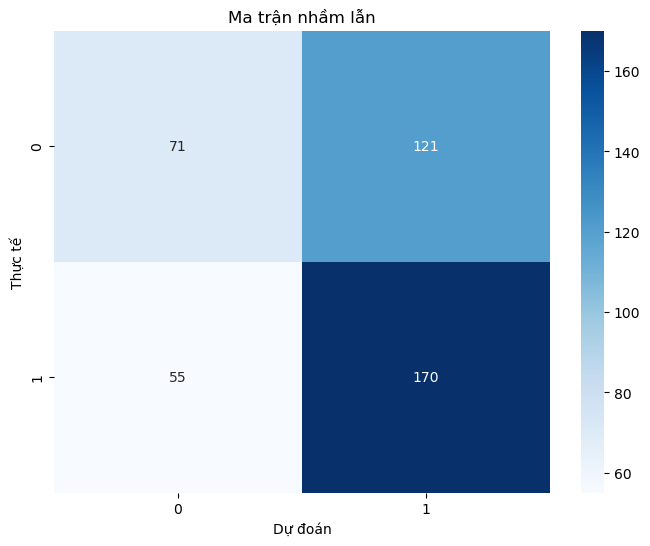

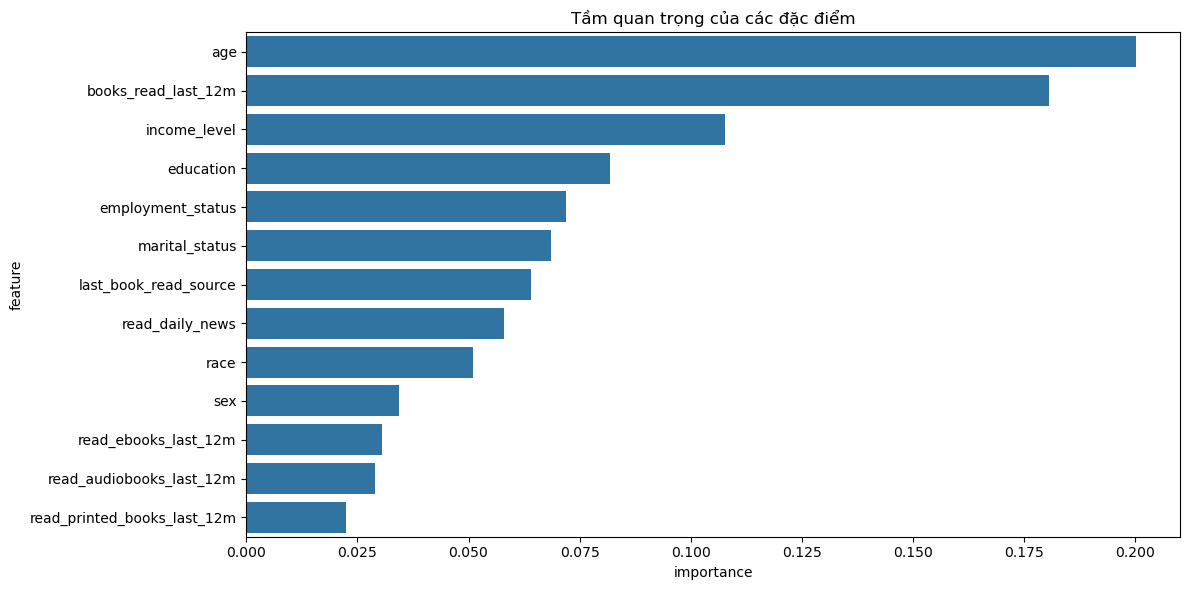


Dự đoán cho người mới:
Có đọc tạp chí: Có
Xác suất đọc tạp chí: 84.38%


In [48]:
if __name__ == "__main__":
    X, y, encoders, scaler = prepare_data(df6)
    model, X_train, X_test, y_train, y_test = train_model(X, y)
    evaluate_model(model, X_test, y_test, X_train, y_train)
    
    # Ví dụ dự đoán
    new_person = {
        'age': 46,
        'sex': 'Male',
        'race': 'Native American',
        'marital_status': 'Married',
        'education': 'High school',
        'employment_status': 'Employed full-time',
        'income_level': '<$10k',
        'books_read_last_12m': 97,
        'read_printed_books_last_12m': 'Yes',
        'read_audiobooks_last_12m': 'Yes',
        'read_ebooks_last_12m': 'Yes',
        'last_book_read_source': 'Purchased',
        'read_daily_news': 'Yes'
    }
    
    prediction, probability = predict_magazine_reading(new_person, model, encoders, scaler)
    print(f"\nDự đoán cho người mới:")
    print(f"Có đọc tạp chí: {'Có' if prediction == 1 else 'Không'}")
    print(f"Xác suất đọc tạp chí: {probability:.2%}")

### 4. Nhận xét và rút ra kết luận

**Nhận xét**

- Đối với dự đoán "Không đọc tạp chí" (Nhãn 0):
    - Precision: 0.56 - Khi mô hình dự đoán một người không đọc tạp chí, nó đúng trong 56% trường hợp
    - Recall: 0.37 - Mô hình chỉ phát hiện được 37% số người thực sự không đọc tạp chí
    - F1-score: 0.45 - Chỉ số tổng hợp cho thấy hiệu suất khá thấp trong việc dự đoán người không đọc tạp chí
- Đối với dự đoán "Có đọc tạp chí" (Nhãn 1):
    - Precision: 0.58 - Khi mô hình dự đoán một người có đọc tạp chí, nó đúng trong 58% trường hợp
    - Recall: 0.76 - Mô hình phát hiện được 76% số người thực sự đọc tạp chí
    - F1-score: 0.66 - Hiệu suất khá hơn trong việc dự đoán người có đọc tạp chí
- Hiệu suất tổng thể:
    - Accuracy: 0.58 - Mô hình dự đoán đúng 58% các trường hợp
    - Cross-validation: 0.624 (±0.020) - Độ chính xác trung bình qua 5 lần kiểm tra là 62.4%, với độ lệch chuẩn thấp (2%) cho thấy mô hình khá ổn định


**Kết luận**

- Mô hình có xu hướng thiên về dự đoán "có đọc tạp chí" (recall cao hơn cho nhãn 1)
- Hiệu suất tổng thể ở mức trung bình, nhóm sẽ nghiên cứu để cải thiện thêm
- Mô hình ổn định qua các lần kiểm tra cross-validation

# **C. TỰ ĐÁNH GIÁ**

|<center><div style="width:150px">Họ và tên</div>|<div style="width:250px">Khó khăn</div>|<div style="width:250px">Bài học </div>|
|---------- |:-------------:|:-------------:|
| <center>Phan Thảo Nguyên |<left> <br> Data không quá thú vị nên khó khăn trong việc đưa ra insight<br> Code còn dài và chưa tối ưu<br>Phần đặt câu hỏi và trả lời chưa được tốt như mong muốn| Học thêm nhiều phương thức giúp code tối ưu hơn <br>Kinh nghiệm lựa chọn dataset phù hợp<br> Cách làm việc nhóm trên github|
| <center>Nguyễn Thị Anh Thi |<left> Sử dụng github khi làm việc nhóm<br>Data chưa đủ hấp dẫn đa dạng và phân phối chưa tốt, nên khi đặt câu hỏi gặp khó khăn để đạt được tiêu chuẩn đề bài<br>Lựa chọn mô hình phù hợp với câu hỏi| Tìm hiểu nhiều hơn về github <br>Chọn lọc data kĩ càng hơn<br>Tìm hiểu kĩ hơn về các mô hình của ML|
| <center>Nguyễn Đoàn Minh Uyên |<left> Làm việc nhóm với git, github<br>Đặt câu hỏi và tìm insight thú vị vì dữ liệu không có nhiều feature, phân phối lớp không đều<br>| Cách làm việc trên các branch (fetch và merge)<br>Điểm mạnh yếu của các phương pháp filling missing value cho cột phân loại<br>Phân tích dữ liệu xem các feature này có phù hợp cho câu hỏi|

**Nếu có nhiều thời gian hơn, nhóm em sẽ:**
- Tổ chức nhiều buổi họp hơn để cùng thảo luận, kỹ càng hơn trong việc lựa chọn một bộ dữ liệu thú vị hơn.
- Đưa ra thêm các câu hỏi mang tính ý nghĩa, sâu sắc hơn nhằm khai thác nhiều hơn những thông tin mà dữ liệu mang lại.
- Viết code ngắn gọn và đơn giản nhất có thể.
- Học thêm nhiều các trực quan hóa dữ liệu.
- Điều chỉnh mô hình dự đoán mà nhóm đề xuất để đạt được độ chính xác cao hơn.

# **D. TÀI LIỆU THAM KHẢO**

- Phạm Trọng Nghĩa, (2023), [Slide bài giảng Lập trình khoa học dữ](https://drive.google.com/drive/folders/1FyzNTCs_xpx-CUVBw_VwXlEt73tf8ywX)
- [Reading habit Dataset](https://www.kaggle.com/datasets/vipulgote4/reading-habit-dataset/data).